In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Sparse matrix imports
from scipy.sparse import coo_matrix

# Starting a session with the API
qctrl = Qctrl()

In [42]:
def simulate_more_realistic_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    # 1. Limits for drive amplitudes
    assert np.amax(values) <= 1.0
    assert np.amin(values) >= -1.0
    max_drive_amplitude = 2 * np.pi * 20  # MHz

    # 2. Dephasing error
    dephasing_error = -2 * 2 * np.pi  # MHz

    # 3. Amplitude error
    amplitude_i_error = 0.98
    amplitude_q_error = 1.03

    # 4. Control line bandwidth limit
    cut_off_frequency = 2 * np.pi * 10  # MHz
    resample_segment_count = 1000

    # 5. SPAM error confusion matrix
    confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

    # Lowering operator
    b = np.array([[0, 1], [0, 0]])
    # Number operator
    n = np.diag([0, 1])
    # Initial state
    initial_state = np.array([[1], [0]])
    
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    sigma_m = np.array([[0, 1], [0, 0]])
    hadamard = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    hadamard_leak = np.array(
        [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
    ) / np.sqrt(2)
    qubit_projector = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.complex)
    sigma_x_leak = np.array(
    [[0, 1.0, 0], [1.0, 0, 0], [0, 0, 1.]], dtype=np.complex)

    with qctrl.create_graph() as graph:
        # Apply 1. max Rabi rate.
        values = values * max_drive_amplitude

        # Apply 3. amplitude errors.
        values_i = np.real(values) * amplitude_i_error
        values_q = np.imag(values) * amplitude_q_error
        values = values_i + 1j * values_q
        
        
        gamma_max = 2 * np.pi * 30e6  # Hz
        alpha_max = 2 * np.pi * 30e6  # Hz
        segment_count = 50

        gamma_i = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segment_count,
        randomized_frequencies_count=10,
        )
        gamma_q = qctrl.operations.real_fourier_pwc_signal(
            duration=duration,
            segments_count=segment_count,
            optimizable_frequencies_count=10,
        )

        # Apply 4. bandwidth limits
        drive_unfiltered = qctrl.operations.pwc_signal(duration=duration,
                                                       values=qctrl.operations.complex_value(
                                                           real=gamma_i.values, imag=gamma_q.values),
                                                      name = 'gamma')
        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_unfiltered,
            kernel_integral=qctrl.operations.sinc_integral_function(cut_off_frequency),
        )
        drive = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=resample_segment_count
        )

        # Construct microwave drive
        drive_term = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Construct 2. dephasing term.
        dephasing_term = qctrl.operations.constant_pwc_operator(
            operator=dephasing_error * n,
            duration=duration,
        )

        # Construct Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_term,
                dephasing_term,
            ]
        )
        
#         target_operator = qctrl.operations.target(
#             sigma_x_leak.dot(qubit_projector), filter_function_projector=qubit_projector
#         )
        target_operator = qctrl.operations.target(operator=sigma_x)
        
        #DIOGO
        infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=qctrl.operations.pwc_sum([drive_term, dephasing_term]),
        target_operator=target_operator,
        noise_operators=[dephasing_term],
        name="infidelity",
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"
        
    # Run the optimization
    optimization_result = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=["gamma"],
        graph=graph,
    )
    
    print(optimization_result)

    print("Optimized cost:\t", optimization_result.cost)

    # Plot the optimized controls
    plot_controls(
        plt.figure(),
        controls={
            "$\\gamma$": optimization_result.output["gamma"],
        },
    )
    plt.show()

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    true_measurements = np.random.choice(2, size=shots, p=populations)
    measurements = np.array(
        [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
    )

    results = {"unitary": unitary, "measurements": measurements}

    return results

In [43]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
h_duration = np.pi / (2 * max_rabi_rate)  # us
shots = 1024

values = np.array([1.0])

<ipython-input-42-7df420b9bc58>:37: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=np.complex
<ipython-input-42-7df420b9bc58>:39: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qubit_projector = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.complex)
<ipython

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 47s.
Result(cost=0.00019131588530402552, output={'gamma': [{'value': (2749.0280822901414+12.829411873805771j), 'duration': 0.000125}, {'value': (2815.7388112419812+16.3780133188178j), 'duration': 0.000125}, {'value': (2880.775806190599+17.893626906056863j), 'duration': 0.000125}, {'value': (2942.4597169384574+17.171250095658525j), 'duration': 0.000125}, {'value': (2999.2244809206272+14.244404196350454j), 'duration': 0.000125}, {'value': (3049.6873393253322+9.3828694452502j), 'duration': 0.000125}, {'value': (3092.7103866473826+3.06582418915481j), 'duration': 0.000125}, {'value': (3127.450057742361-4.0668507043621025j), 'duration': 0.000125}, {'value': (3153.3916005817778-11.280078053646546j), 'duration': 0.000125}, {'value': (3170.366443595444-17.819136237737805j), 'duration': 0.000125}, {'value': (3178.551390367854-22.987453257017364j), 'duration': 0.000125}, {'value': (3178.4496936737714-2

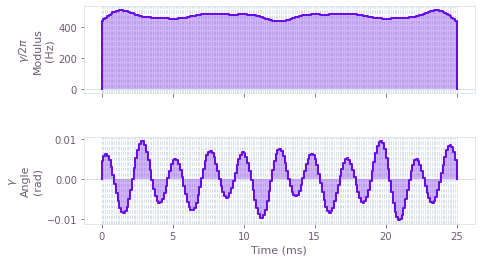

QctrlGqlException: The following errors occurred:
- Error(fields=['graph'], message="The operation 'real_fourier_pwc_signal' is not available to use as part of the calculate graph function.")

In [44]:
not_results = simulate_more_realistic_qubit(
    duration=not_duration, values=values, shots=shots
)
h_results = simulate_more_realistic_qubit(
    duration=h_duration, values=values, shots=shots
)

In [6]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

In [8]:
def get_pulse_plot_dict(name="default", duration=1, values=np.array([1.0])):
    segments = len(values)
    segment_durations = duration / segments
    pulse_plot_dict = {
        name: [{"duration": segment_durations, "value": v} for v in values]
    }
    return pulse_plot_dict
def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)

In [9]:
realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, -1j], [-1j, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]
not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")

print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

Realised NOT Gate:
[[0.75412104-0.02524955j 0.1026601 -0.64817036j]
 [0.1026601 -0.64817036j 0.70940919+0.25704996j]]
Ideal NOT Gate:
[[ 0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j]]
NOT Gate Error:0.5693360860922008
NOT estimated probability of getting 1:0.4208984375
NOT estimate standard error:0.015428227947108762

Realised H Gate:
[[0.98219782-0.00092913j 0.01473832-0.18726817j]
 [0.01473832-0.18726817j 0.96995998+0.15456728j]]
Ideal H Gate:
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
H Gate Error:0.31912041750757547
H estimated probability of getting 1:0.0537109375
H estimate standard error:0.0070451995439541615


In [10]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

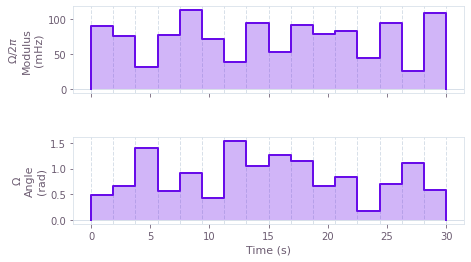

In [11]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [12]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


In [13]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
control #2: [0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
control #3: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
control #4: [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]


In [14]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 0.88, P(|1>) = 0.12, P(|2>) = 0.00
control #2: P(|0>) = 0.56, P(|1>) = 0.44, P(|2>) = 0.00
control #3: P(|0>) = 0.09, P(|1>) = 0.91, P(|2>) = 0.00
control #4: P(|0>) = 0.59, P(|1>) = 0.41, P(|2>) = 0.00


In [15]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
With  1 repetitions: P(|0>) = 0.31, P(|1>) = 0.69, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.16, P(|1>) = 0.84, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.66, P(|1>) = 0.34, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.22, P(|1>) = 0.78, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.62, P(|1>) = 0.38, P(|2>) = 0.00
